# Pertussis Model
1. [Model](#Model)
1. [Results](#Results)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from scipy.integrate import odeint
%matplotlib inline

from time import clock, sleep
from datetime import datetime as dt
from pprint import pprint

from pertussis import *

## Initial Parameters

In [4]:
# # Initial Parameters
t_start = 1948
t_end = 2015
step = 1 / N
# t_start = expand_time(t_start, step=step)
t_end = expand_time(t_end, step=step)
t_range = np.arange(t_start, t_end + 0, 1)

## Data Loading

In [5]:
# # Data
data = np.genfromtxt('./data/yearly.csv', delimiter=',', skip_header=1)[:, 1]

years = np.genfromtxt('./data/yearly.csv', delimiter=',', skip_header=1)[:, 0]
data /= 100000
# TODO: Data Monthly
# data_month
# months

In [ ]:
#######################
###### Run Model ######
#######################
# i0 = pm.Uniform("Is0", 0, 0.1)
# s0 = pm.Uniform("S0", 0.1, 1 - i0)


# # State 0
# @pm.deterministic
# def state_0(S=s0, I=i0):
#     state_0 = collect_state0(S, I)
#     # state_0 = pack_flat(state_0)
#     return state_0

## Model

In [75]:
times = []
state_0 = collect_state0()
state_0 = pack_flat(state_0)

# Priors
o = pm.Uniform('omega', 3, 6)
p = pm.Uniform('phi', 0, o + 0.1)
f1 = pm.Uniform('f1', 0, 0.5)
f2 = pm.Uniform('f2', 0, 0.5)
f3 = pm.Uniform('f3', 0, 0.5)
z = pm.Uniform('zeta', 0, 4)

@pm.deterministic
def f(f1=f1, f2=f2, f3=f3):
    s1, s2 = 5, 4
    s3 = J - s1 - s2
    return np.concatenate((f1 * np.ones(s1),
                           f2 * np.ones(s2),
                           f3 * np.ones(s3)))






@pm.deterministic
def sim(o=o, p=p, f=f, z=z):
    # print('A ', end="")
    clk = clock()
    res = odeint(hetro_model, pack_flat(state_0), t_range,
                 args=(o, p, f, z))

    # print (RES.shape)
    # print(RES.sum(axis=1))
    res = unpack(res.T, *unpack_values)
    # print (RES[3].shape)
    # res = reduce_year(RES[3].sum(axis=0))[1951 - t_start:2014 - t_start]
    # print (res.shape)
    # print(clock() - clk)
    times.append(clock() - clk)
    return res


@pm.deterministic
def mu1(sim=sim):
    res = reduce_year(sim[3].sum(axis=0))[1951 - t_start:2014 - t_start]
    return res


# TODO: Two sigmas
sigma1 = pm.Uniform('sigma1', 0, 0.5)
# sigma2 = pm.Uniform('sigma2', 0, sigma1/12)
Y1 = pm.Normal('Y1', mu=mu1, tau=1 / sigma1 ** 2, observed=True, value=data)
# Y2 = pm.Normal('Y2', mu=mu2, tau=1 / sigma2 ** 2, observed=True, value=data_monthly)

# TODO: Set weights? Is it possible?

# model = pm.Model([Y1, o, p, sim, f, f1, f2, f3, mu1, sigma1, s0, i0, state_0, z])
model = pm.Model([Y1, o, p, sim, f, f1, f2, f3, mu1, sigma1, z])

In [76]:
# TODO: Other Backend
mcmc = pm.MCMC(model, db="ram")
mcmc.sample(iter=2, burn=0)  #######################################################################################

 [--------------------------150%---------------------------] 3 of 2 complete in 14.5 sec

# Results
## Prepare Results and run model with parameters

In [78]:
# m_s = mcmc.trace('S0')[t_tally:].mean()
# m_i = mcmc.trace('Is0')[t_tally:].mean()
t_tally = 0
m_f = mcmc.trace('f')[t_tally:].mean()
m_o = mcmc.trace('omega')[t_tally:].mean()
m_p = mcmc.trace('phi')[t_tally:].mean()
m_z = mcmc.trace('zeta')[t_tally:].mean()

# Show mean values fit
state_0 = collect_state0()
state_0 = pack_flat(state_0)
RES = odeint(hetro_model, state_0, t_range,
             args=(m_o, m_p, m_f, m_z))
# # Results
x = reduce_time(t_range, start=t_start, step=step)
y = unpack(RES.T, *unpack_values)
h = sum([i for i in y[:3]])
all = sum([i for i in y])
y.append(h)
y.append(all)
# with open('./data/x.p', 'wb') as fl:
#     pickle.dump([x, y, years, data], fl)

2.6998143250393696


## Charting

[ 1.02444444  1.02444056  1.02443667 ...,  1.00459859  1.00459832
  1.00459805]


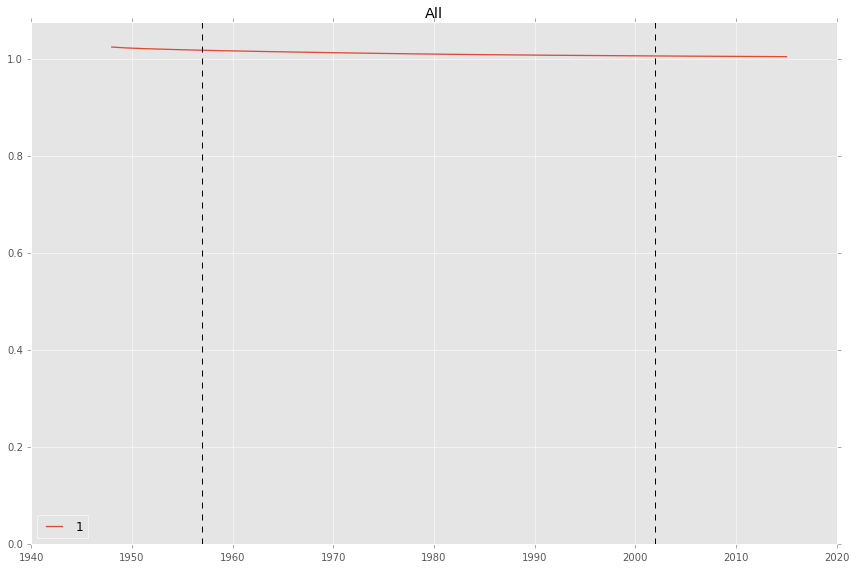

In [79]:
fig, ax = draw_model(x, y[-1:], ["All"], split=0, collapse=True)

plt.tight_layout()
z = y[-1:][0]
print (z.sum(axis=0))
plt.show()

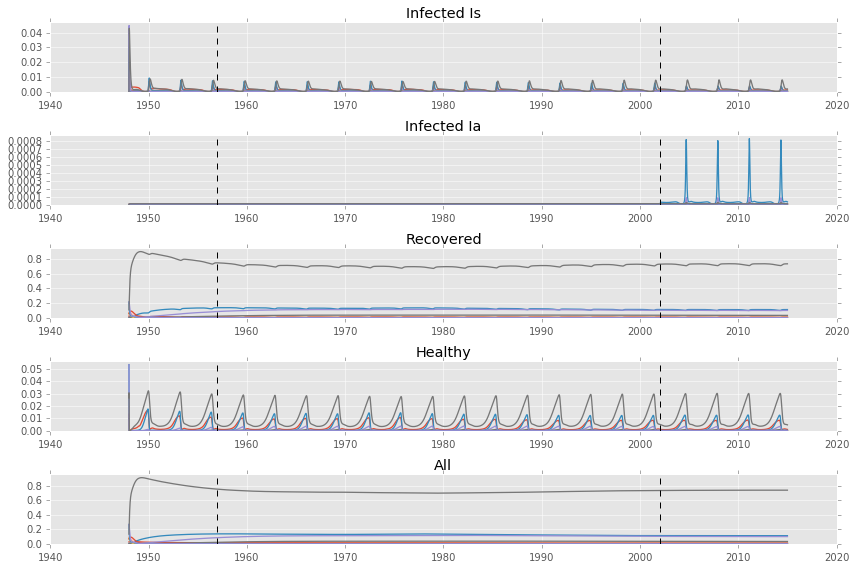

In [80]:
fig, ax = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=False)

plt.tight_layout()
plt.show()

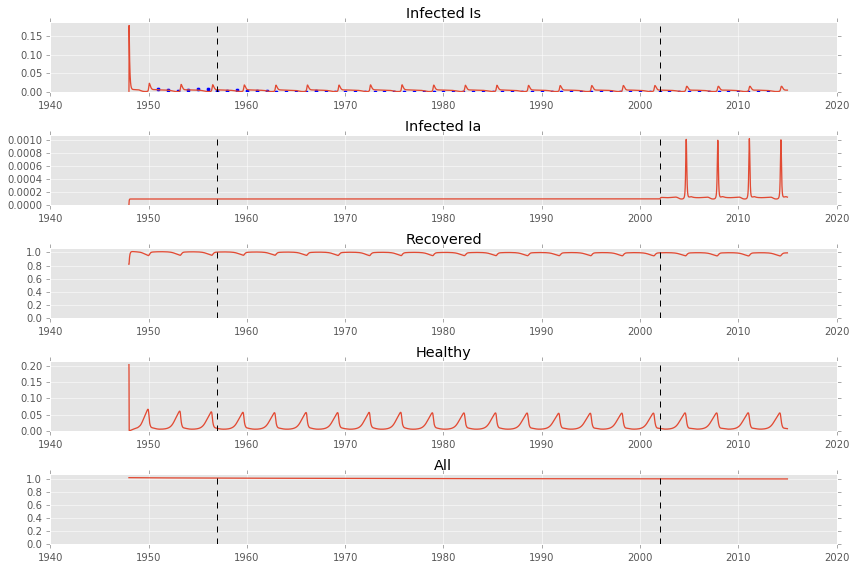

In [81]:
fig, ax = draw_model(x, y[3:], ["Infected Is", "Infected Ia", "Recovered", "Healthy", "All"], split=0, collapse=True)
plt.tight_layout()
ax[0].scatter(years, data)
plt.show()

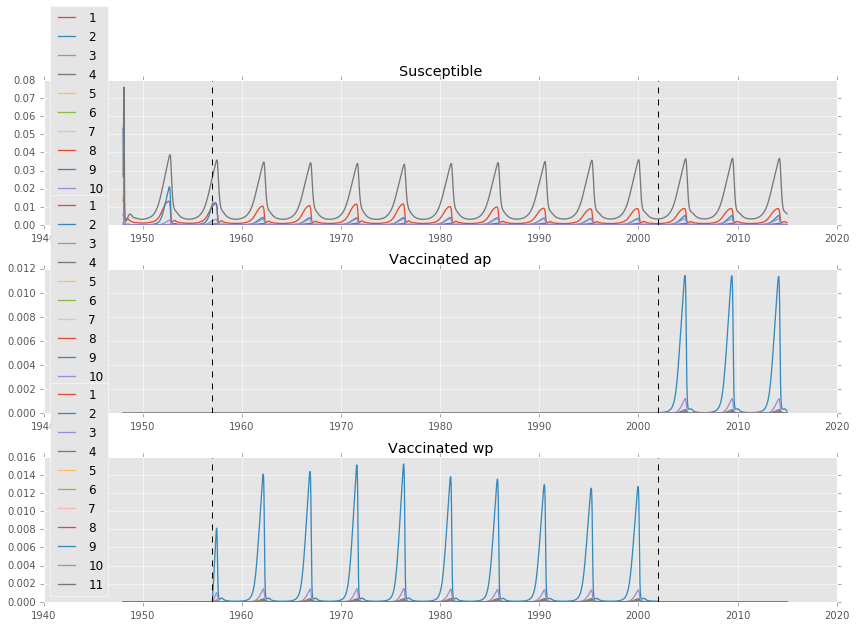

In [43]:
fig2, ax2 = draw_model(x, y[0:3], ["Susceptible", "Vaccinated ap", "Vaccinated wp"], split=False, collapse=False)
plt.tight_layout()
plt.show()

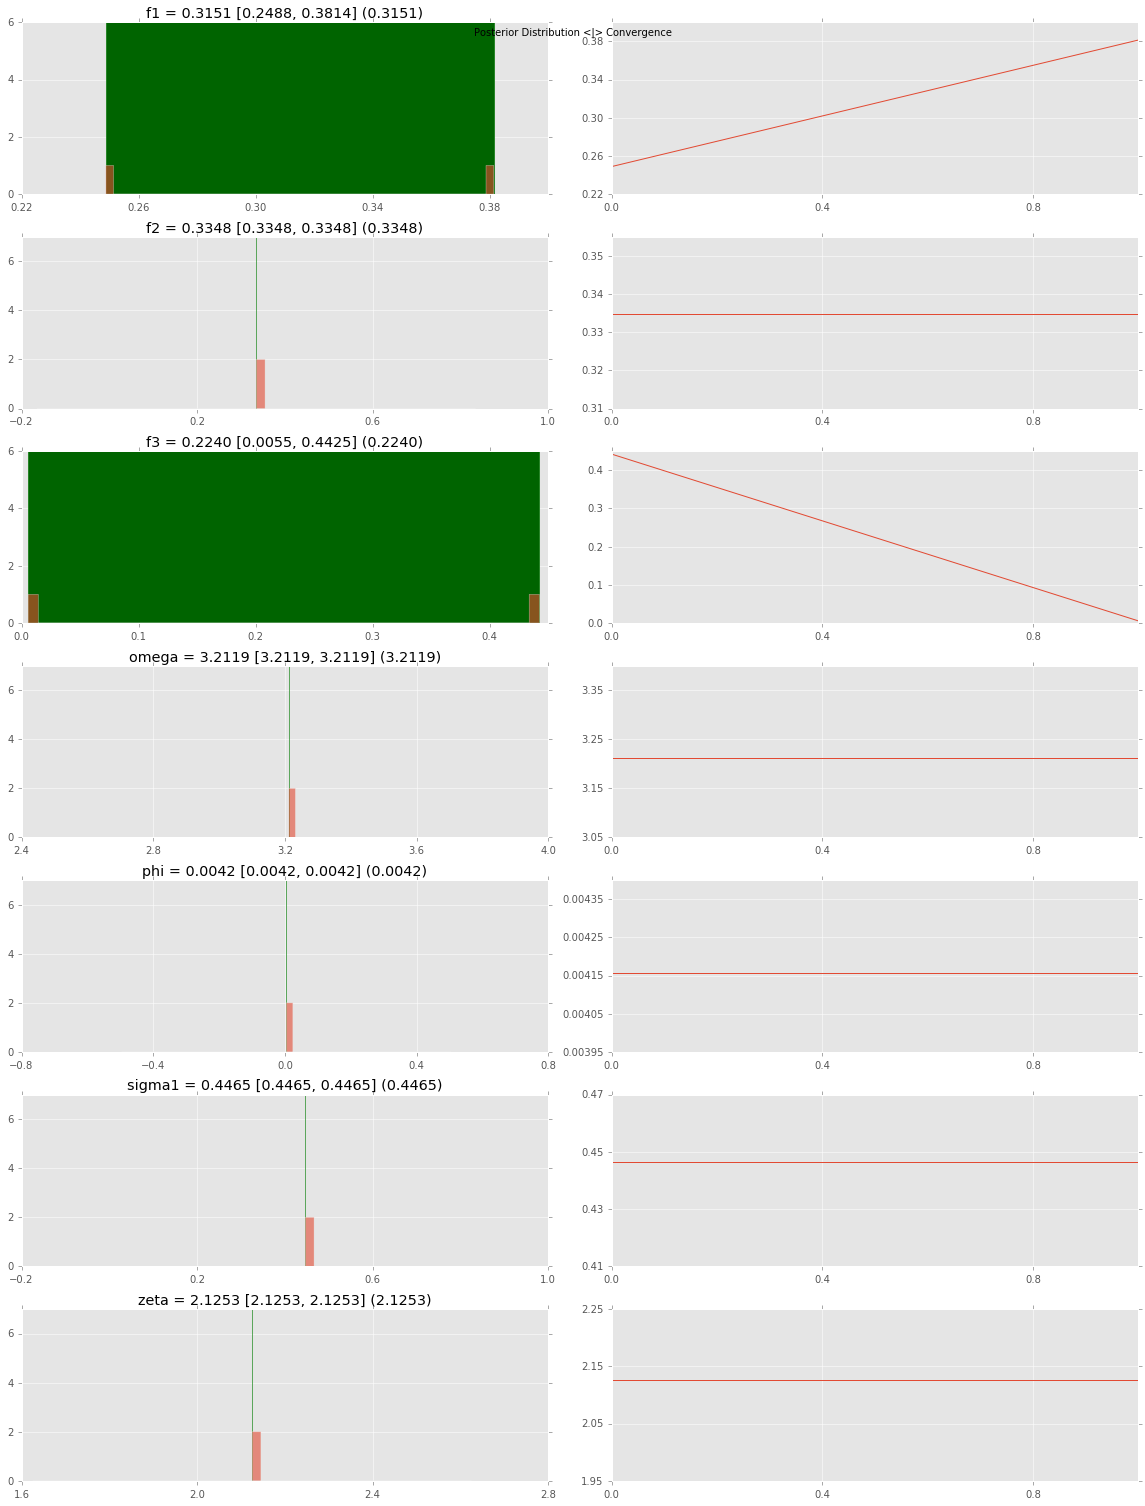

In [83]:

fig4, ax4 = plot_stoch_vars(mcmc)
fig4.savefig('./img/mcmc{}.png'.format(dt.utcnow()).replace(':', '-'))
for ax in ax3:
    ax.set_xlim(1955, 2013)
ax3[0].set_ylim(0, 0.05)

plt.tight_layout()
plt.show()